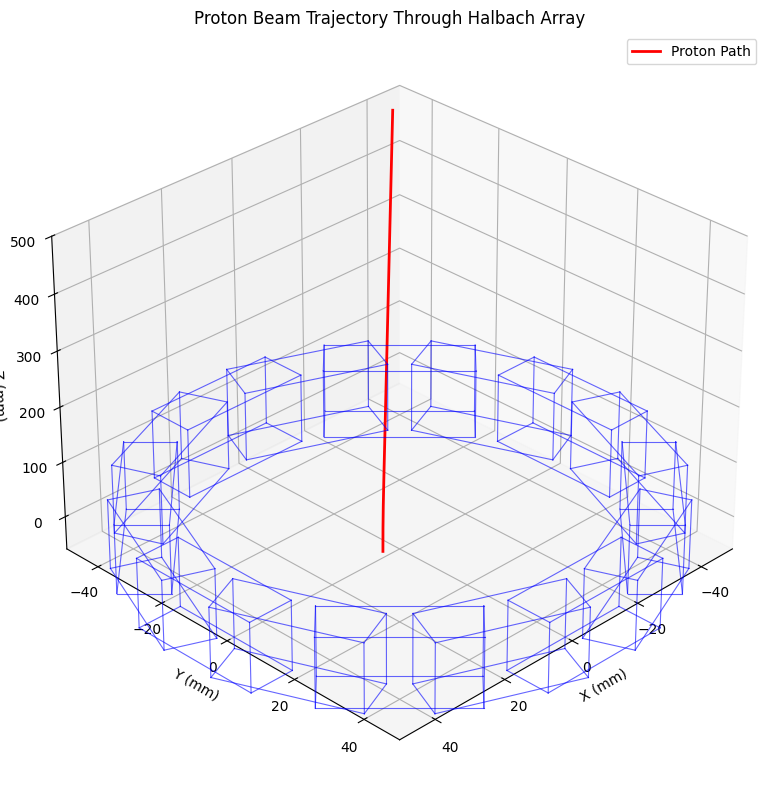

In [105]:
import numpy as np
import magpylib as mag
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants
proton_energy_MeV = 300
proton_mass_MeV = 938.272
c = 3e8
e = 1.602e-19
proton_mass_kg = 1.6726e-27

# Relativistic velocity
total_energy = proton_energy_MeV + proton_mass_MeV
gamma = total_energy / proton_mass_MeV
beta = np.sqrt(1 - 1 / gamma**2)
v = beta * c

def create_halbach_ring_3d(num_magnets=16, inner_radius=36.5e-3, outer_radius=70.2e-3, length=126.4e-3):
    ring = mag.Collection()
    magnet_thickness = (outer_radius - inner_radius)
    magnet_width = 2 * np.pi * inner_radius / num_magnets * 0.8  # 80% of circumferential space
    magnet_size = np.array([magnet_width, magnet_thickness, length])
    
    for i in range(num_magnets):
        theta = 2 * np.pi * i / num_magnets
        radius = inner_radius + magnet_thickness/2
        pos = np.array([radius * np.cos(theta), radius * np.sin(theta), 0])
        
        # Quadrupole Halbach rule: magnetization angle = 2*theta
        angle = 2 * theta
        
        # Using N52 neodymium magnetization (~1.48 T)
        mag_strength = 1.48 / (4*np.pi*1e-7)  # A/m
        magnetization = np.array([
            mag_strength * np.cos(angle),
            mag_strength * np.sin(angle),
            0
        ])
        
        m = mag.magnet.Cuboid(
            magnetization=magnetization,
            dimension=magnet_size,
            position=pos,
        )
        m.rotate_from_angax(np.degrees(theta), 'z', anchor=pos)
        ring.add(m)
    return ring, magnet_size
# Create single Halbach array
halbach_array, magnet_size = create_halbach_ring_3d()

# Function to get cuboid vertices
def get_cuboid_vertices(cuboid):
    # Get cuboid properties
    pos = np.array(cuboid.position)
    dim = np.array(cuboid.dimension)
    rot = cuboid.orientation.as_rotvec()
    
    # Local cuboid vertices (before rotation/translation)
    half_dim = dim/2
    vertices_local = np.array([
        [-half_dim[0], -half_dim[1], -half_dim[2]],
        [ half_dim[0], -half_dim[1], -half_dim[2]],
        [ half_dim[0],  half_dim[1], -half_dim[2]],
        [-half_dim[0],  half_dim[1], -half_dim[2]],
        [-half_dim[0], -half_dim[1],  half_dim[2]],
        [ half_dim[0], -half_dim[1],  half_dim[2]],
        [ half_dim[0],  half_dim[1],  half_dim[2]],
        [-half_dim[0],  half_dim[1],  half_dim[2]],
    ])
    
    # Rotate vertices
    if np.linalg.norm(rot) > 0:
        rot_matrix = cuboid.orientation.as_matrix()
        vertices_rotated = np.dot(vertices_local, rot_matrix.T)
    else:
        vertices_rotated = vertices_local
    
    # Translate vertices
    vertices_global = vertices_rotated + pos
    
    return vertices_global

# Lorentz force
def lorentz_force(q, v, B):
    return q * np.cross(v, B)

# Initial conditions - starting slightly off-center to see focusing
pos = np.array([0.005, 0.0, -0.05])  # 5 mm offset in x, 5 cm before array
velocity = np.array([0.0, 0.0, v])
dt = 1e-11
num_steps = 400

# Track particle
positions = []
velocities = []

for _ in range(num_steps):
    B = halbach_array.getB(pos)
    force = lorentz_force(e, velocity, B)
    acc = force / proton_mass_kg
    velocity += acc * dt
    pos += velocity * dt
    positions.append(pos.copy())

positions = np.array(positions)

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot proton path
ax.plot3D(positions[:, 0]*1000, positions[:, 1]*1000, positions[:, 2]*1000, 
          color='red', label='Proton Path', linewidth=2)

# Plot Halbach array magnets
for magnet in halbach_array.sources_all:
    vertices = get_cuboid_vertices(magnet)
    
    # Define the edges of the cuboid
    edges = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
        [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
        [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
    ]
    
    # Plot each edge
    for edge in edges:
        ax.plot(
            [vertices[edge[0], 0]*1000, vertices[edge[1], 0]*1000],
            [vertices[edge[0], 1]*1000, vertices[edge[1], 1]*1000],
            [vertices[edge[0], 2]*1000, vertices[edge[1], 2]*1000],
            color='blue', alpha=0.6, linewidth=0.8
        )

ax.set_title("Proton Beam Trajectory Through Halbach Array", fontsize=12)
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")
ax.legend()
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-60, 500])

ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.show()


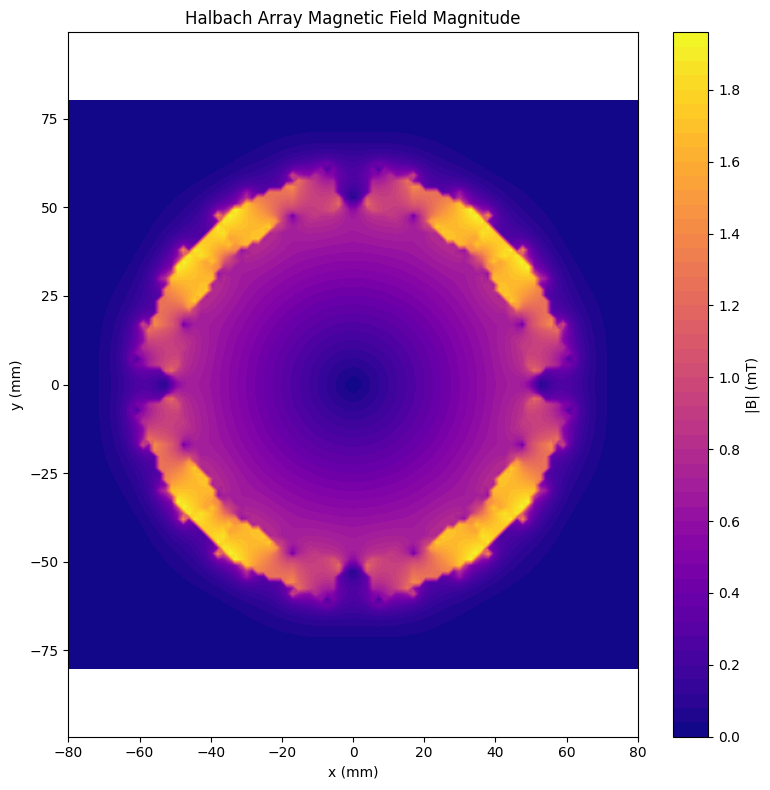

In [104]:
grid_x, grid_y = np.meshgrid(np.linspace(-80, 80, 100), np.linspace(-80, 80, 100))
positions = np.stack([grid_x, grid_y, np.zeros_like(grid_x)], axis=-1) / 1000
B = halbach_array.getB(positions)
B_mag = np.linalg.norm(B, axis=-1)

plt.figure(figsize=(8, 8))
plt.contourf(grid_x, grid_y, B_mag, levels=50, cmap="plasma")
plt.colorbar(label="|B| (mT)")
plt.title("Halbach Array Magnetic Field Magnitude")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.axis("equal")
plt.tight_layout()
plt.show()